<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondAI-2024/blob/main/emeka/Wine_Dataset_Code_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a code that compares Kolmogorov Arnold Networks (KANs) with the Multi-Layer Pereptron (MLPs) using the wine dataset

I aim to use graphical representation to understand how each model converges, the maximum accuracy achieved by each model, the loss each model has while training on the dataset.

The comparison would also be done using some criterias such as precision,recall,f1 score and confusion matrix

##Import Necessary Libraries

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git
!apt-get install python3.10-venv  # Install the Python 3.10 virtual environment package
!python3.10 -m venv .venv310       # Create a virtual environment named .venv310 using Python 3.10
!source .venv310/bin/activate
!python --version  # 3.10.12
!pip install scikit-learn==1.6.0 pandas==2.2.2 matplotlib==3.8.0 torch==2.5.1+cu121 numpy==1.26.4
!pip install git+https://github.com/trevorstephens/gplearn.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-iop8nlv8
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-iop8nlv8
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.7).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Python 3.10.12
  Cloning https://github.com/trevorstephens/gplearn.git to /tmp/pip-req-build-3byfndk4
  Running command git clone --filter=blob:none --quiet https://github.com/trevorstephens/gplearn.git /tmp/pip-req-build-3byfndk4
  Resolved https://github.com/trevorstephens/gplearn.git to commit 64517a85fd6d6c50f9ee9e5599f97458da278951
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from sklearn.utils.estimator_checks import check_estimator
import time
torch.manual_seed(123)
import warnings
warnings.filterwarnings("ignore")

##Models
The models are being called with their default hyperparameter and layers


In [3]:
# MLP Model
mlp = MLPClassifier()
# KAN Model
kan = KAN(width=[2,2,1]) # should be adjusted based on dataset

checkpoint directory created: ./model
saving model version 0.0


#Functions
All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix,plotting the graph are written here.

##Model Functions

In [50]:
def MLP_run(mlp,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  train_accuracies,test_accuracies = [],[]
  train_losses,test_losses = [],[]
  criterion = nn.MSELoss()
  start_time = time.time()

  for epoch in range(epochs):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_pred_train = mlp.predict(X_train)
    train_acc = accuracy_score(y_train, torch.tensor(y_pred_train))
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_accuracies.append(train_acc)
    train_losses.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Train Loss: {train_loss.item():.4f}, MLP Train Accuracy: {train_acc:.4f}')

  for epoch in range(epochs):
    y_pred_test = mlp.predict(X_test)
    test_acc = accuracy_score(torch.tensor(y_test), torch.tensor(y_pred_test))
    test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    test_accuracies.append(test_acc)
    test_losses.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Test Loss: {test_loss.item():.4f}, MLP Test Accuracy: {test_acc:.4f}')
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_accuracies,test_accuracies,train_losses,test_losses,MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.long)
  y_test = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()

  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(X_train)
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(y_train, predicted)
    train_loss = loss_fn(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.4f}, KAN Train Accuracy: {train_accuracy:.4f}')

  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test, predicted.argmax(1))
    test_loss = loss_fn(predicted, y_test)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.4f},KAN Test Accuracy: {test_accuracy:.4f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [5]:
def run_models(mlp_model,kan_model,epochs):
  mlp_model_run = MLP_run(mlp_model,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  mlp_metrics = [mlp_model_run[0],mlp_model_run[1],mlp_model_run[2],mlp_model_run[3]]
  print(f'MLP Execution time: {mlp_model_run[4]:.2f} seconds')

  kan_model_run = KAN_run(kan_model,x_train_tensor,y_train_long,x_test_tensor,y_test_long,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')
  return mlp_metrics,kan_metrics

##Plot Function

In [6]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics
    plt.figure(figsize=(10,5))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(121)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue',marker='x')
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='red',marker='x')
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='green',marker='x')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='yellow',marker='x')
    plt.ylim(0.5, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP and KAN Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(122)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss',color='blue',marker='x')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss',color='red',marker='x')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [7]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  y_pred_mlp = mlp.predict(x_test_tensor)
  y_pred_kan = kan(x_test_tensor).argmax(1)
  mlp_classification= classification_report(y_test_tensor, y_pred_mlp)
  kan_classification = classification_report(y_test_long, y_pred_kan)
  mlp_confusion = confusion_matrix(y_test_tensor, y_pred_mlp)
  kan_confusion = confusion_matrix(y_test_long, y_pred_kan)
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

##KAN Hyperparameter Tunning Function

In [25]:
class KANWrapper:
    def __init__(self, width, grid=3, k=2, noise_scale=0.1, mult_arity=2, seed=123):
        self.width = width
        self.grid = grid
        self.k = k
        self.noise_scale = noise_scale
        self.mult_arity = mult_arity
        self.seed = seed
        self.model = KAN(width=width, grid=grid, k=k, noise_scale=noise_scale, mult_arity=mult_arity, seed=seed)
    def fit(self, X, y):
        self.model.update_grid_from_samples(torch.tensor(X, dtype=torch.float32))  # Assuming X is a NumPy array
        return self
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)  # Assuming X is a NumPy array
        outputs = self.model(X_tensor)
        return outputs.argmax(1).numpy()
    def get_params(self, deep=True):
        return {"width": self.width,
                "grid": self.grid,
                "k": self.k,
                "noise_scale": self.noise_scale,
                "mult_arity": self.mult_arity,
                "seed": self.seed
               }
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.model = KAN(width=self.width, grid=self.grid, k=self.k, noise_scale=self.noise_scale, mult_arity=self.mult_arity, seed=self.seed)
        return self

def kan_hyperparameter(kan_tune,x_train_tensor,y_train_tensor):
  param_grid_kan0 = {'grid':[4,5,6],
                    'k':[2,3,4],
                    'noise_scale':[0.0001,0.01,0.1,0.001]}
  clfkan = GridSearchCV(kan_tune, param_grid_kan0, cv=5, scoring='accuracy')
  clfkan.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
  return f"Best parameters: {clfkan.best_params_}"

#Dataset
The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [9]:
url_wine = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url_wine)
df['Wine'] = df['Wine'].replace({1: 0, 2: 1, 3: 2})
x = df.drop('Wine', axis=1).values
y = df['Wine'].values

##Prepare Dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_train_long = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_test_long = torch.tensor(y_test, dtype=torch.long)

# Model Run
Running the models over 100 epochs with different hidden layers for MLP and KAN with that of KAN being lower than MLP at all points

Plotting the accuracies and loss over epochs

Calculating other comparison criteria like the classification report and confusion matrix

In [54]:
epochs = 100

## Model Run with 2 hidden layers of 27 and 10 neurons respectively




In [34]:
# mlp hyperparameter tunning for mlp0
param_grid_mlp0 = {
    'hidden_layer_sizes': [(27,10)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.1,0.00001],
    'learning_rate':['adaptive','constant']}
mlp_tune0 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp0 = GridSearchCV(mlp_tune0, param_grid_mlp0, cv=5, scoring='accuracy')
clfmlp0.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp0.best_params_}")

Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (27, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'adam'}


In [ ]:
# Remove comment to run the code using ctrl + /
kan_tune0 = KANWrapper(width=[13,27,10,3], seed=123)
print(kan_hyperparameter(kan_tune0,x_train_tensor,y_train_tensor))
# Result:  Best parameters: {'grid': 5, 'k': 2, 'noise_scale': 0.0001}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [20/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [30/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [40/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [50/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [60/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [70/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [80/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [90/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [100/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [10/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [20/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [30/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [40/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [50/100],MLP T

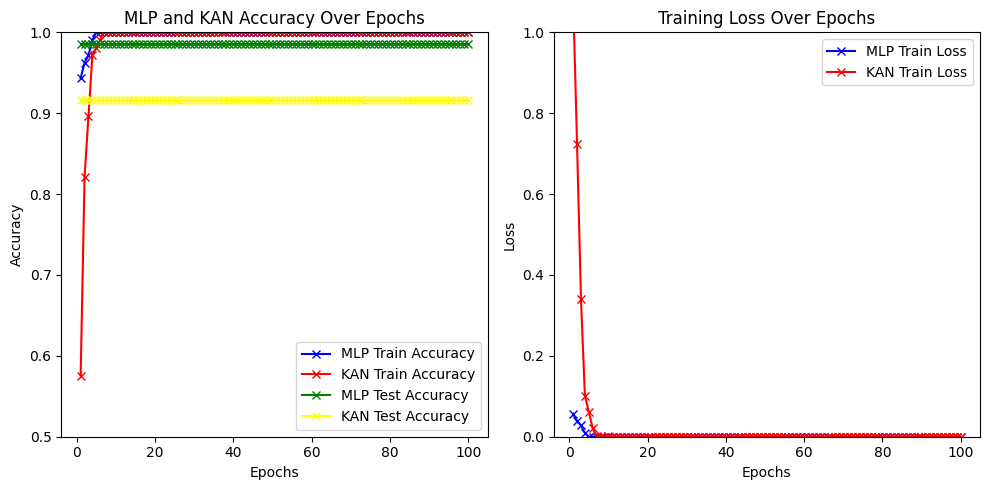

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      0.96      0.98        27
         2.0       0.95      1.00      0.97        19

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

MLP Confusion Matrix:
[[26  0  0]
 [ 0 26  1]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       1.00      0.85      0.92        27
           2       0.94      0.89      0.92        19

    accuracy                           0.92        72
   macro avg       0.93      0.92      0.92        72
weighted avg       0.93      0.92      0.92        72

KAN Confusion Matrix:
[[26  0  0]
 [ 3 23  1]
 [ 2  0 17]]


In [60]:
# MLP Model
mlp_0 = MLPClassifier(hidden_layer_sizes=(27,10),
                    max_iter= 1000,
                    activation='tanh',
                    learning_rate_init= 0.1,
                    learning_rate='adaptive',
                    alpha= 0.001,
                    solver='adam',
                    random_state=123,
                    verbose = False)

# KAN Model
kan_0 = KAN(width=[13,27,10,3], grid=5, k=2, noise_scale=0.0001,seed=123)
mlp_metrics_0,kan_metrics_0 = run_models(mlp_0,kan_0,epochs)
plot_comparison_over_epochs(mlp_metrics_0, kan_metrics_0,epochs)
mlp_0.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_0,kan_0,x_test_tensor,y_test_tensor)

## Model Run with 2 hidden layers of 40 and 15 neurons respectively

In [44]:
# mlp hyperparameter tunning for mlp1
param_grid_mlp1 = {
    'hidden_layer_sizes': [(40,15)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.0001],
    'learning_rate':['adaptive','constant']}
mlp_tune1 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp1 = GridSearchCV(mlp_tune1, param_grid_mlp1, cv=5, scoring='accuracy')
clfmlp1.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp1.best_params_}")

Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40, 15), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [ ]:
# # Remove comment to run the code using ctrl + /
# kan_tune1 = KANWrapper(width=[13,40,15,3], seed=123)
# print(kan_hyperparameter(kan_tune1,x_train_tensor,y_train_tensor))
# # Results:  Best parameters: {'grid': 6, 'k': 2, 'noise_scale': 0.0001}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.0283, MLP Train Accuracy: 0.9717
Epoch [20/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [30/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [40/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [50/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [60/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [70/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [80/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [90/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [100/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [10/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [20/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [30/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [40/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [50/100],MLP T

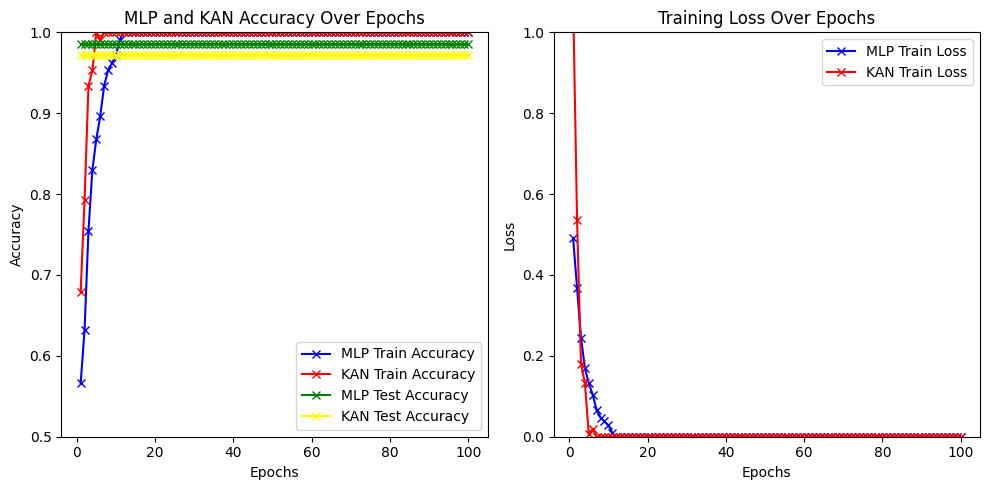

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        26
         1.0       1.00      0.96      0.98        27
         2.0       1.00      1.00      1.00        19

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

MLP Confusion Matrix:
[[26  0  0]
 [ 1 26  0]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.96      0.98        27
           2       1.00      0.95      0.97        19

    accuracy                           0.97        72
   macro avg       0.98      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72

KAN Confusion Matrix:
[[26  0  0]
 [ 1 26  0]
 [ 1  0 18]]


In [43]:
mlp_1 = MLPClassifier(hidden_layer_sizes=(40,15),
                    max_iter=1000,
                    activation='tanh',
                    learning_rate_init= 0.01,
                    learning_rate='adaptive',
                    alpha= 0.1,
                    solver='adam',
                    random_state=123,
                    verbose = False)


kan_1= KAN(width=[13,40,15,3], grid=6, k=2, noise_scale=0.0001, seed=123)
kan_1.update_grid_from_samples(x_train_tensor)
num_epochs = 100
mlp_metrics_1,kan_metrics_1 = run_models(mlp_1,kan_1,num_epochs)
plot_comparison_over_epochs(mlp_metrics_1, kan_metrics_1,num_epochs)
mlp_1.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_1,kan_1,x_test_tensor,y_test_tensor)

## Model Run with 2 hidden layers of 15 and 7 neurons respectively

In [18]:
# mlp hyperparameter tunning for mlp2
param_grid_mlp2 = {
    'hidden_layer_sizes': [(15,7)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.001,0.1],
    'learning_rate':['adaptive','constant']}
mlp_tune2 = MLPClassifier(max_iter=1000, random_state=123)
clfmlp2 = GridSearchCV(mlp_tune2, param_grid_mlp2, cv=5, scoring='accuracy')
clfmlp2.fit(x_train_tensor.numpy(), y_train_tensor.numpy())
print(f"Best parameters: {clfmlp2.best_params_}")

Best parameters: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (15, 7), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'adam'}


In [ ]:
# # Remove comment to run the code using ctrl + /
# kan_tune2 = KANWrapper(width=[13,15,7,3], seed=123)
# print(kan_hyperparameter(kan_tune2,x_train_tensor,y_train_tensor))
# # Result:  Best parameters: {'grid': 6, 'k': 3, 'noise_scale': 0.1}

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [20/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [30/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [40/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [50/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [60/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [70/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [80/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [90/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [100/100],MLP Train Loss: 0.0000, MLP Train Accuracy: 1.0000
Epoch [10/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [20/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [30/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [40/100],MLP Test Loss: 0.0139, MLP Test Accuracy: 0.9861
Epoch [50/100],MLP T

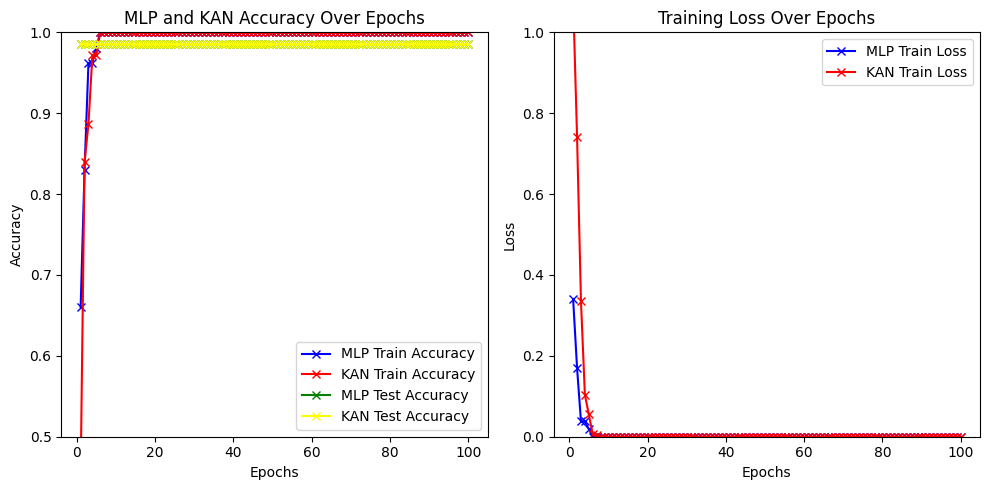

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      1.00      1.00        27
         2.0       1.00      1.00      1.00        19

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

MLP Confusion Matrix:
[[26  0  0]
 [ 0 27  0]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.96      0.98        27
           2       1.00      1.00      1.00        19

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

KAN Confusion Matrix:
[[26  0  0]
 [ 1 26  0]
 [ 0  0 19]]


In [62]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(15,7),
                    max_iter=1000,
                    activation='relu',
                    learning_rate_init= 0.1,
                    learning_rate='adaptive',
                    alpha= 1,
                    solver='adam',
                    random_state=42,
                    verbose = False)


kan_2= KAN(width=[13,15,7,3], grid=6, k=3, noise_scale=0.1, seed=123)
kan_2.update_grid_from_samples(x_train_tensor)
num_epochs = 100
mlp_metrics_2,kan_metrics_2 = run_models(mlp_2,kan_2,num_epochs)
plot_comparison_over_epochs(mlp_metrics_2, kan_metrics_2,num_epochs)
mlp_2.fit(x_test_tensor, y_test_tensor)
criteria_comparison(mlp_2,kan_2,x_test_tensor,y_test_tensor)